In [804]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats
from statsmodels.stats import diagnostic
import scipy as sp


In [805]:
df = pd.read_csv("opp-stops_state.csv")
counties =  pd.read_csv('2016_US_County_Level_Presidential_Results.csv')

In [806]:
# drop all NaN values
df.drop(columns = ['city', 'geography'], inplace = True)
df.dropna(inplace = True)
counties = counties.dropna()
# add number of searches column
df['nb_searches'] = df.search_rate * df.stops_per_year


In [807]:
#Définir array des états bleus et rouges
red_states = ['SC', 'TX']
blue_states  = ['IL', 'CT', 'RI']

#Fonction pour trier les états en blue et red: 
def what_color (name): #retourne toujours none !
    if any(s == name for s in blue_states):
        return 'blue'
    elif any(s == name for s in red_states):
        return 'red'
    else:
        return 'none'
    
def sort_array_of_state(dataframe):
    colors = []
    for state in dataframe['state']:
        colors.append(what_color(state))
    return colors
    
#Trier les états de notre dataframe:
df['party'] = sort_array_of_state(df)


In [808]:
blue = df[df['party'].str.contains('blue')].reset_index(drop = True)
red = df[df['party'].str.contains('red')].reset_index(drop = True)
full = pd.concat([blue,red]).reset_index(drop = True)
full_pivot = full.pivot(index = ['party', 'state', 'subgeography'] , columns = 'subject_race')
full_pivot.head()

search_rate                     stop_rate  \
subject_race                        black  hispanic     white     black   
party state subgeography                                                  
blue  CT    Fairfield County     0.029384  0.020520  0.013487  0.073116   
            Hartford County      0.036567  0.036986  0.012005  0.073116   
            Litchfield County    0.034749  0.038982  0.016265  0.073116   
            New Haven County     0.028742  0.030105  0.011492  0.073116   
            New London County    0.031647  0.029246  0.014475  0.073116   

                                                   hit_rate            \
subject_race                   hispanic     white     black  hispanic   
party state subgeography                                                
blue  CT    Fairfield County   0.039236  0.065458  0.315113  0.257426   
            Hartford County    0.039236  0.065458  0.303398  0.294776   
            Litchfield County  0.039236  0.065458  0.301587  0.438776   
            New Haven County   0.039236  0.065458  0.247191  0.302548   
            New London County  0.039236  0.065458  0.331683  0.325926   

                                        inferred_threshold  ...            \
subject_race                      white              black  ...     white   
party state subgeography                                    ...             
blue  CT    Fairfield County   0.356108           0.171864  ...  0.223550   
            Hartford County    0.319820           0.155822  ...  0.238114   
            Litchfield County  0.413978           0.184323  ...  0.262494   
            New Haven County   0.357401           0.166497  ...  0.233488   
            New London County  0.335580           0.172387  ...  0.225318   

                              stops_per_year                    stop_rate_n  \
subject_race                           black hispanic     white       black   
party state subgeography                                                      
blue  CT    Fairfield County         5080.32  4725.12  17189.76    25650.72   
            Hartford County          5408.16  3623.00  17752.80    25650.72   
            Litchfield County         906.50  1257.00  16466.88    25650.72   
            New Haven County         5945.28  5006.40  23139.36    25650.72   
            New London County        3063.84  2215.68  24605.76    25650.72   

                                                   nb_searches           \
subject_race                   hispanic      white       black hispanic   
party state subgeography                                                  
blue  CT    Fairfield County   21654.72  160113.12      149.28    96.96   
            Hartford County    21654.72  160113.12      197.76   134.00   
            Litchfield County  21654.72  160113.12       31.50    49.00   
            New Haven County   21654.72  160113.12      170.88   150.72   
            New London County  21654.72  160113.12       96.96    64.80   

                                       
subject_race                    white  
party state subgeography               
blue  CT    Fairfield County   231.84  
            Hartford County    213.12  
            Litchfield County  267.84  
            New Haven County   265.92  
            New London County  356.16  

[5 rows x 21 columns]

We will be examining hit rates and threshold, they are computed individually for each subject race and each county.

These variables are ....

They depend on the number of searches:

(118.81183750799273, 70.39172426420102)

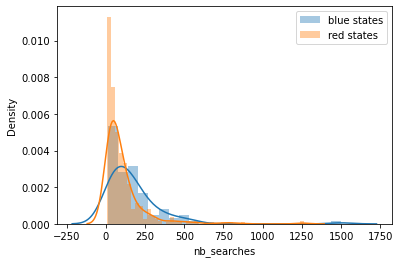

In [809]:
g = sns.distplot(blue.nb_searches, label = 'blue states')
sns.distplot(red.nb_searches, label = 'red states', ax = g)
plt.legend()
full.nb_searches.mean(), full.nb_searches.median()

As we can see the number of searches per county and per subject race follows a power law distribution. This is indeed due to the fact that, like city sizes, county sizes follow a power law distribution since there is a majority of small, low population counties with a heavy tail of large counties with high population.

(0.3033774690616758, 0.3561253711992615)

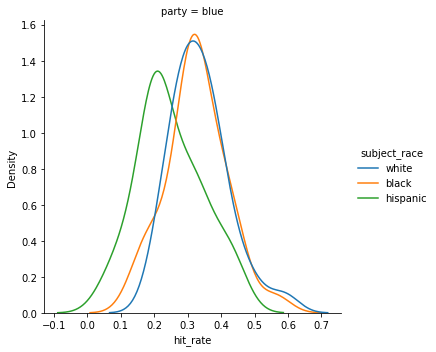

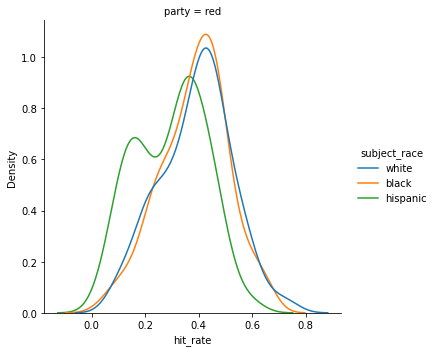

In [810]:
#we can add distribution of hit rate and threshold but boxplots look fine to me.
sns.displot(data=blue, x="hit_rate", hue="subject_race", col="party", kind="kde")
# fig, axes = plt.subplots(2,2,figsize = (8,8))
# parties = [blue,red]
# value = ['hit_rate', 'inferred_threshold']
# for i in range(4):
#     print(i%2)
#     sns.displot(data=parties[i%2], x=value[i%2], hue="subject_race", col="party", kind="kde", ax = axes[i%2,i%2])

# fig,ax=plt.subplots()

sns.displot(data=red, x="hit_rate", hue="subject_race", col="party", kind="kde", ax =ax)
# we can plot the non weighted vs weighted means for blue and red states to compare with the distribution
blue.hit_rate.mean(), red.hit_rate.mean()

<AxesSubplot:xlabel='subject_race', ylabel='inferred_threshold'>

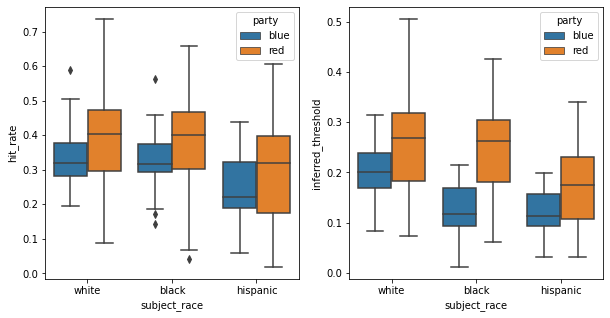

In [811]:
# boxplots also give a good representation of distribution and shit
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.boxplot(data=full, y="hit_rate", x="subject_race", hue = 'party', ax = ax[0])
sns.boxplot(data=full, y="inferred_threshold", x="subject_race", hue = 'party', ax = ax[1])

We describe here our two variables of interest over our whole working dataset (blue and red states).
Values look overall pretty close, hispanic rates being lower.

Now its time to test our data, but for this we need to know what test to use and to know what test to use we need to know what kind of distribution the data has. Therefore we use statistical tests.

In [812]:
# Here we do some diagnostics. 
# We want to know if the county specific, race specific hit rates and thresholds have normal distribution
# We can do this either over the full dataframe or over the blue and red dataframes separately
diagnostic.kstest_normal(full_pivot.loc['red'].inferred_threshold.hispanic, dist = 'norm')

(0.07866208425108001, 0.0414062467744477)

In [843]:
# both these tests allow us to examine correlation between two variables
# we can for example look at the correlation between a dependent variable and the hit rate or threshold as these are the independent
# variables we would like to assess
# spearman does not take the assumption that data is normally distributed
print(stats.spearmanr(full['inferred_threshold'],full['hit_rate']))
print(stats.spearmanr(full['nb_searches'],full['hit_rate']))
print(stats.spearmanr(full['nb_searches'],full['inferred_threshold']))

SpearmanrResult(correlation=0.8585609764310043, pvalue=2.4298148536076406e-157)
SpearmanrResult(correlation=-0.13885515863802225, pvalue=0.0012559093273109832)
SpearmanrResult(correlation=-0.23679512999655253, pvalue=2.796766404058407e-08)


We can see for example that hit rate and threshold are quite well correlated whereas number of searches and hit_rate are actually negatively correlated! This goes to show that increasing the number of searches may not actually increase the chances of finding contraband. Rather the more you search the more likely you are to find nothing. 

In [844]:
print(stats.spearmanr(full_pivot.loc['red']['nb_searches','hispanic'],full_pivot.loc['red']['hit_rate','hispanic']))
print(stats.spearmanr(full_pivot['nb_searches','black'], full_pivot['hit_rate','black']))
print(stats.spearmanr(full_pivot['nb_searches','hispanic'], full_pivot['hit_rate','hispanic']))

SpearmanrResult(correlation=0.148823185358741, pvalue=0.0710390610171311)
SpearmanrResult(correlation=-0.42128284611037853, pvalue=4.292020147034426e-09)
SpearmanrResult(correlation=0.12712871577165907, pvalue=0.08991654432313753)


We can see above how we might use correlation to explore some causalities, however this is quite naive and superficial analysis.

Our objective is to compare our independent variables (hit rate and inferred threshold) between blue and red states. Nevertheless, the visualizations are not enough to see a difference. Therefore, we will carry out tests on these variables to determine if significant differences exist between blue and red states. 

First we will calculate the mean race specific hit rates and thresholds for blue states and red states. This can be done by giving each county an equal weight (unweighted mean) or giving each county a weight proportional to the race specific number of searches (weighted mean).
Then we choose a statistical test and carry it out to compare race specific, party specific mean hit rates and thresholds.

In [815]:
print("unweighted means:", blue.hit_rate.mean(), red.hit_rate.mean(), blue.inferred_threshold.mean(), red.inferred_threshold.mean())

unweighted means: 0.3033774690616758 0.3561253711992615 0.15203333226969742 0.2245221985323473


In [816]:
full.head()
full.groupby(['party','subject_race']).mean().loc[:,'hit_rate':'inferred_threshold']

hit_rate  inferred_threshold
party subject_race                              
blue  black         0.325693            0.127468
      hispanic      0.248095            0.124068
      white         0.336344            0.204564
red   black         0.384179            0.245381
      hispanic      0.294927            0.171971
      white         0.389270            0.256215

Now we calculate the weighted means by giving each county a race specific weight. 

Each row will hence get a weight: 
w(i) = nb_searches(i)/sum(nb_searches of corresponding race in dataframe)

This will be done for blue and red dataframe so as to give higher weight to counties with a lot of searches and less to counties with few.

In [817]:
def get_weight(nb_searches):
    return nb_searches/nb_searches.sum()
def get_normalize(values):
    return values/values.white
# def weighted_mean()

In [818]:
import warnings
warnings.filterwarnings('ignore')
#create dataframes with normalized values, using the pivoted dataframe so we can apply get normalize to each row containing race specific
hit_rate_normalized = full_pivot.hit_rate.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'hit_rate_normalized'})
threshold_normalized = full_pivot.inferred_threshold.apply(get_normalize, axis = 1).stack('subject_race').reset_index().rename(columns = {0:'threshold_normalized'})

blue = blue.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography','state', 'subject_race','party'])
red = red.merge(hit_rate_normalized.merge(threshold_normalized), on = ['subgeography','state', 'subject_race','party'])


weights = full_pivot.loc['blue'].nb_searches.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
blue = blue.merge(weights, on = ['subgeography','state', 'subject_race'])

weights = full_pivot.loc['red'].nb_searches.apply(get_weight, axis = 0).stack('subject_race').reset_index().rename(columns = {0:'weight'})
red = red.merge(weights, on = ['subgeography','state', 'subject_race'])


blue['hit_rate_weighted'] = blue.hit_rate*blue.weight
blue['threshold_weighted'] = blue.inferred_threshold*blue.weight
red['hit_rate_weighted'] = red.hit_rate*red.weight
red['threshold_weighted'] = red.inferred_threshold*red.weight
blue['hit_rate_weighted_normalized'] = blue.hit_rate_normalized*blue.weight
blue['threshold_weighted_normalized'] = blue.threshold_normalized*blue.weight
red['hit_rate_weighted_normalized'] = red.hit_rate_normalized*red.weight
red['threshold_weighted_normalized'] = red.threshold_normalized*red.weight

In [819]:
blue
red
# full_normalized.head()

,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,nb_searches,party,hit_rate_normalized,threshold_normalized,weight,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized
0,SC,Aiken County,white,0.046344,0.152224,0.326098,0.135749,14778.447761,4.748885e+05,684.895522,red,1.000000,1.000000,0.030084,0.009810,0.004084,0.030084,0.030084
1,SC,Aiken County,black,0.047768,0.198882,0.311993,0.093137,8785.074627,2.627670e+05,419.641791,red,0.956746,0.686097,0.031066,0.009692,0.002893,0.029722,0.021314
2,SC,Aiken County,hispanic,0.097844,0.113592,0.171032,0.054565,1188.000000,3.037415e+04,116.238806,red,0.524481,0.401955,0.009948,0.001701,0.000543,0.005218,0.003999
3,SC,Anderson County,white,0.025694,0.152224,0.277738,0.165177,29465.373134,4.748885e+05,757.074627,red,1.000000,1.000000,0.033255,0.009236,0.005493,0.033255,0.033255
4,SC,Anderson County,black,0.036149,0.198882,0.301578,0.131444,8789.552239,2.627670e+05,317.731343,red,1.085836,0.795777,0.023522,0.007094,0.003092,0.025541,0.018718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,TX,Williamson County,black,0.025413,0.067230,0.494577,0.305252,3181.428571,2.150716e+05,80.851079,red,1.246905,1.094380,0.005985,0.002960,0.001827,0.007463,0.006550
440,TX,Williamson County,hispanic,0.024083,0.069734,0.322340,0.200787,6339.714286,7.443300e+05,152.682007,red,0.812670,0.719856,0.013067,0.004212,0.002624,0.010619,0.009406
441,TX,Wise County,white,0.015098,0.091078,0.451655,0.317677,16829.714286,1.070666e+06,254.101247,red,1.000000,1.000000,0.011161,0.005041,0.003546,0.011161,0.011161
442,TX,Wise County,black,0.043500,0.067230,0.489914,0.277676,1375.285714,2.150716e+05,59.825015,red,1.084708,0.874085,0.004429,0.002170,0.001230,0.004804,0.003871


In [827]:
blue.groupby('subject_race').sum()/blue.groupby('subject_race').sum().loc['white']

,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,nb_searches,hit_rate_normalized,threshold_normalized,weight,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized
subject_race,,,,,,,,,,,,,,
black,2.770698,1.491505,0.968331,0.623118,0.253119,0.272876,0.77698,0.979727,0.608307,1.0,0.809062,0.454041,0.904966,0.492870
hispanic,2.432922,0.624372,0.737623,0.606499,0.149047,0.139113,0.35007,0.728333,0.595508,1.0,0.666077,0.528523,0.685482,0.565019
white,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [825]:
red.groupby('subject_race').sum()/red.groupby('subject_race').sum().loc['white']

,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,nb_searches,hit_rate_normalized,threshold_normalized,weight,hit_rate_weighted,threshold_weighted,hit_rate_weighted_normalized,threshold_weighted_normalized
subject_race,,,,,,,,,,,,,,
black,1.922601,0.932027,0.986922,0.957718,0.347310,0.243448,0.593343,1.011336,0.968235,1.0,0.982693,0.886964,1.068757,0.926526
hispanic,2.161214,0.759019,0.757641,0.671198,0.368658,0.618957,0.513253,0.742274,0.659872,1.0,0.875264,0.786953,0.772833,0.695199
white,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


The obtained results are not the same! But still test necessary.
How will we do the test?

In [836]:
# compare normalized hit rate and threshold between red and blue
# We use mannwhitney test because we ar comparing two samples but our values distribution are not normal
print(stats.mannwhitneyu(blue.hit_rate, red.hit_rate, alternative='two-sided'))
print(stats.mannwhitneyu(blue.hit_rate_normalized, red.hit_rate_normalized, alternative='two-sided'))


MannwhitneyuResult(statistic=15116.0, pvalue=4.8241199695765465e-05)
MannwhitneyuResult(statistic=19562.5, pvalue=0.4171405489457858)


We can see that normalizing is important as it does not give the same results at all. Without normalization the means are clearly not the same. However since the p value is not less than 0.05 we cannot reject the null hypothesis that mean hit rates are the same.

Lets check out some more tests:

In [842]:
print(stats.mannwhitneyu(blue.threshold_normalized, red.threshold_normalized, alternative='two-sided'))
print(stats.mannwhitneyu(blue[blue.subject_race == 'black'].threshold_normalized, 
                         red[red.subject_race == 'black'].threshold_normalized, alternative='two-sided'))
print(stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].threshold_normalized, 
                         red[red.subject_race == 'hispanic'].threshold_normalized, alternative='two-sided'))
print(stats.mannwhitneyu(blue[blue.subject_race == 'black'].hit_rate_normalized, 
                         red[red.subject_race == 'black'].hit_rate_normalized, alternative='two-sided'))
print(stats.mannwhitneyu(blue[blue.subject_race == 'hispanic'].hit_rate_normalized, 
                         red[red.subject_race == 'hispanic'].hit_rate_normalized, alternative='two-sided'))

MannwhitneyuResult(statistic=13071.0, pvalue=1.4028945443066947e-08)
MannwhitneyuResult(statistic=116.0, pvalue=1.0373127111540843e-16)
MannwhitneyuResult(statistic=1510.0, pvalue=0.0028206933708296938)
MannwhitneyuResult(statistic=2135.0, pvalue=0.5457188088401649)
MannwhitneyuResult(statistic=2193.0, pvalue=0.7016478592647909)


In [884]:
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate_normalized, blue[blue.subject_race == 'black'].nb_searches), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate_normalized, red[red.subject_race == 'black'].nb_searches),
                         alternative='two-sided'))
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate, blue[blue.subject_race == 'black'].nb_searches), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate, red[red.subject_race == 'black'].nb_searches),
                         alternative='two-sided'))
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate, blue[blue.subject_race == 'black'].nb_searches), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate, red[red.subject_race == 'black'].nb_searches),
                         alternative='two-sided'))
print(stats.mannwhitneyu(np.repeat(blue[blue.subject_race == 'black'].hit_rate, blue[blue.subject_race == 'black'].nb_searches), 
                         np.repeat(red[red.subject_race == 'black'].hit_rate, red[red.subject_race == 'black'].nb_searches),
                         alternative='two-sided'))

MannwhitneyuResult(statistic=25608488.0, pvalue=8.197822136371379e-306)
MannwhitneyuResult(statistic=28100151.0, pvalue=9.724319945381405e-202)
MannwhitneyuResult(statistic=28100151.0, pvalue=9.724319945381405e-202)
MannwhitneyuResult(statistic=28100151.0, pvalue=9.724319945381405e-202)


Wesh on a choisit Connecticut (55%), Illinois (55%), RI (54%), TX (52%), SC (55%)

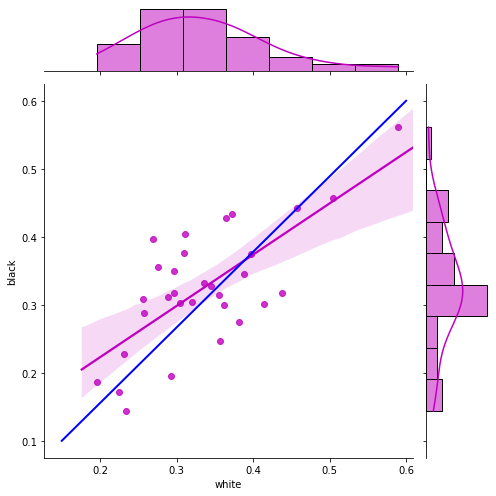

In [37]:
# fig, (ax1,ax2) = plt.subplots(2,1, figsize = (10,10))
# sns.distplot(df_blue_pivot.swaplevel(1,0, axis = 1).black.hit_rate, label = 'black', ax = ax1)
# sns.distplot(df_blue_pivot.swaplevel(1,0, axis = 1).white.hit_rate, label = 'white', ax=ax1 )
# ax1.legend()
# sns.distplot(df_blue_pivot.swaplevel(1,0, axis = 1).hispanic.hit_rate, label = 'blue', ax = ax2)
# sns.distplot(df_red_pivot.swaplevel(1,0, axis = 1).hispanic.hit_rate, label = 'red', ax=ax2)
blue = df_blue_pivot
plot = sns.jointplot(x=blue.hit_rate.white, y=blue.hit_rate.black, data=blue,
                  kind="reg", truncate=False,
                  color="m", height=7)

plot.ax_joint.plot([0.15,0.6], [0.1,0.6], 'b-', linewidth = 2)

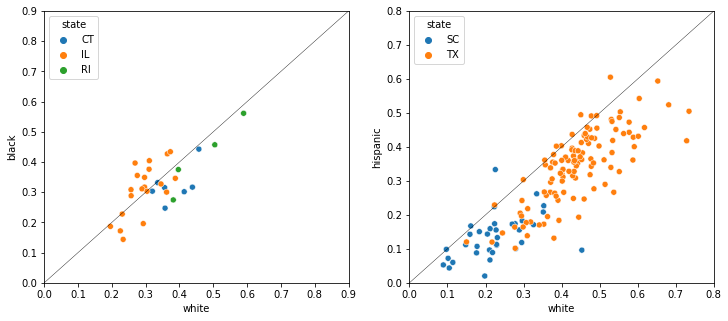

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(range(10),range(10), color = 'black', lw = 0.4)
ax1.set_xlim([0,0.9])  
ax1.set_ylim([0,0.9]) 
g = sns.scatterplot(data = df_blue_pivot, x = df_blue_pivot.hit_rate.white, y = df_blue_pivot.hit_rate.black, hue = 'state', ax =ax1)
# h,l = g.get_legend_handles_labels()
# ax1.legend(h[0:5],l[0:5])

ax2.plot(range(10),range(10), color = 'black', lw = 0.4)
ax2.set_xlim([0,0.8]) 
ax2.set_ylim([0,0.8]) 
sns.scatterplot(data = df_red_pivot, x = df_red_pivot.hit_rate.white, y = df_red_pivot.hit_rate.hispanic, hue = 'state', ax =ax2)
plt.show(g)

In [18]:
df_pivot = pd.concat([df_blue_pivot,df_red_pivot])
df_pivot.head()

search_rate                     stop_rate            \
subject_race                  black  hispanic     white     black  hispanic   
state subgeography                                                            
CT    Fairfield County     0.029384  0.020520  0.013487  0.073116  0.039236   
      Hartford County      0.036567  0.036986  0.012005  0.073116  0.039236   
      Litchfield County    0.034749  0.038982  0.016265  0.073116  0.039236   
      New Haven County     0.028742  0.030105  0.011492  0.073116  0.039236   
      New London County    0.031647  0.029246  0.014475  0.073116  0.039236   

                                   hit_rate                      \
subject_race                white     black  hispanic     white   
state subgeography                                                
CT    Fairfield County   0.065458  0.315113  0.257426  0.356108   
      Hartford County    0.065458  0.303398  0.294776  0.319820   
      Litchfield County  0.065458  0.301587  0.438776  0.413978   
      New Haven County   0.065458  0.247191  0.302548  0.357401   
      New London County  0.065458  0.331683  0.325926  0.335580   

                        inferred_threshold  ... stops_per_year stop_rate_n  \
subject_race                         black  ...          white       black   
state subgeography                          ...                              
CT    Fairfield County            0.171864  ...       17189.76    25650.72   
      Hartford County             0.155822  ...       17752.80    25650.72   
      Litchfield County           0.184323  ...       16466.88    25650.72   
      New Haven County            0.166497  ...       23139.36    25650.72   
      New London County           0.172387  ...       24605.76    25650.72   

                                             nb_searches                   \
subject_race             hispanic      white       black hispanic   white   
state subgeography                                                          
CT    Fairfield County   21654.72  160113.12      149.28    96.96  231.84   
      Hartford County    21654.72  160113.12      197.76   134.00  213.12   
      Litchfield County  21654.72  160113.12       31.50    49.00  267.84   
      New Haven County   21654.72  160113.12      170.88   150.72  265.92   
      New London County  21654.72  160113.12       96.96    64.80  356.16   

                        party                 
subject_race            black hispanic white  
state subgeography                            
CT    Fairfield County   blue     blue  blue  
      Hartford County    blue     blue  blue  
      Litchfield County  blue     blue  blue  
      New Haven County   blue     blue  blue  
      New London County  blue     blue  blue  

[5 rows x 24 columns]

In [692]:
def get_weights(df, states, races):
    df['weights'] = np.zeros(df.shape[0])
    for state in states:
        for race in races:
            df.loc[state,race].weights = df.loc[state,race].nb_searches/df.loc[state,race].nb_searches.sum()
    return df

In [693]:
def add_normalized_rates(df):
    df_white = df[df.subject_race == 'white'].reset_index(drop = True)
    df_black = df[df.subject_race == 'black'].reset_index(drop = True)
    df_hispanic = df[df.subject_race == 'hispanic'].reset_index(drop = True)
    df_black['hit_rate_normalized'] = (df_black.hit_rate / df_white.hit_rate) #*df_black.weights
    df_hispanic['hit_rate_normalized'] = (df_hispanic.hit_rate / df_white.hit_rate)#*df_hispanic.weights
    df_black['threshold_normalized'] = (df_black.inferred_threshold / df_white.inferred_threshold)#*df_black.weights
    df_hispanic['threshold_normalized'] = (df_hispanic.inferred_threshold / df_white.inferred_threshold)#*df_hispanic.weights
    return pd.concat([df_hispanic,df_black])


In [694]:
def weighted_mean(x):
#     print(x)
    return np.mean(x)

In [695]:
# plot bar graphs by political orientation (blue/red) and by method (hit rate/threshold)
def plot_bar(method, data, params):
    ylim, ax = params
    sns.barplot(x = "state", y = method, hue = "subject_race", data = data, estimator = np.mean, ax = ax)
    ax.set_ylim(ylim)
    ax.set_xlim([-0.5,4.5])
    ax.axhline(y=1, ls = (1, (10,5)), color = 'black', lw = 0.7)
    x = np.arange(-0.5, 2.5, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#5DADE2", alpha =0.5)    
    x = np.arange(2.5, 5, 0.01)
    ax.fill_between(x, ylim[0],ylim[1], color = "#E74C3C", alpha =0.5)
#     ax.set_xlim(lim)
#     ax.set_ylim(lim)

,state,subgeography,subject_race,search_rate,stop_rate,hit_rate,inferred_threshold,stops_per_year,stop_rate_n,nb_searches,party,weight,hit_rate_weighted,threshold_weighted
0,CT,Fairfield County,white,0.013487,0.065458,0.356108,0.223550,17189.76,160113.12,231.84,blue,0.031126,0.011084,0.006958
1,CT,Fairfield County,black,0.029384,0.073116,0.315113,0.171864,5080.32,25650.72,149.28,blue,0.025794,0.008128,0.004433
2,CT,Fairfield County,hispanic,0.020520,0.039236,0.257426,0.198470,4725.12,21654.72,96.96,blue,0.037185,0.009572,0.007380
3,CT,Hartford County,white,0.012005,0.065458,0.319820,0.238114,17752.80,160113.12,213.12,blue,0.028612,0.009151,0.006813
4,CT,Hartford County,black,0.036567,0.073116,0.303398,0.155822,5408.16,25650.72,197.76,blue,0.034171,0.010367,0.005325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,RI,500,black,0.072370,0.124369,0.457045,0.160940,2412.60,7196.00,174.60,blue,0.030169,0.013789,0.004855
89,RI,500,hispanic,0.067899,0.044056,0.421182,0.152781,2391.80,6780.60,162.40,blue,0.062282,0.026232,0.009515
90,RI,900,white,0.016673,0.041327,0.396657,0.244227,7893.20,31961.60,131.60,blue,0.017668,0.007008,0.004315
91,RI,900,black,0.032466,0.124369,0.375000,0.211771,1429.20,7196.00,46.40,blue,0.008018,0.003007,0.001698


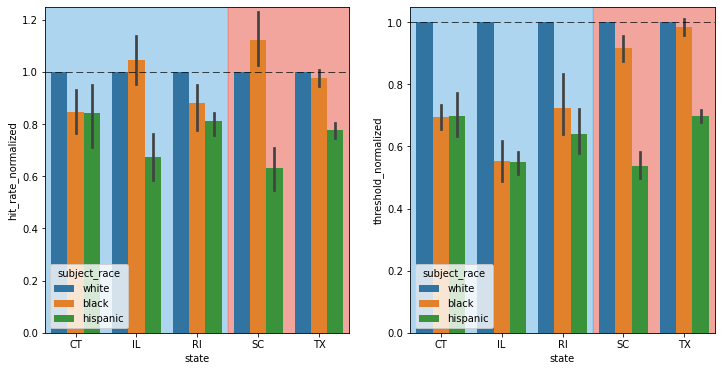

In [702]:
# blue.groupby('state').sum()
# data.groupby(['state','subject_race']).sum()
# blue.set_index(['state','subject_race']).loc['CT','white']
# blue
# full = pd.concat([blue,red])
# full_normalized = add_normalized_rates(full)
races = full.subject_race.unique()
states = full.state.unique()

# temp =  get_weights(full.set_index(['state','subject_race']), states, races) 
# data = add_normalized_rates(temp.reset_index())
# data = add_normalized_rates(full)
methods = ["hit_rate_normalized", "threshold_normalized"]
ylim = [[0,1.25], [0,1.05]]
fig, axs = plt.subplots(1,2,figsize=(12,6))
for method in range(2):
    params = [ylim[method],axs[method]]
    plot_bar(methods[method],full_normalized, params)
blue

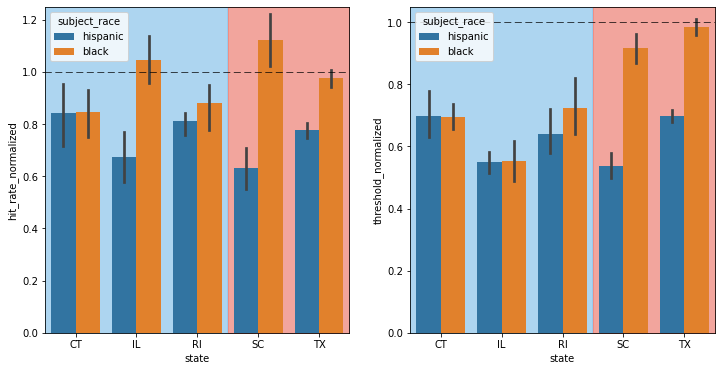

In [697]:
full = pd.concat([blue,red])
# full_normalized = add_normalized_rates(full)
races = full.subject_race.unique()
states = full.state.unique()

# temp =  get_weights(full.set_index(['state','subject_race']), states, races) 
# data = add_normalized_rates(temp.reset_index())
data = add_normalized_rates(full)
methods = ["hit_rate_normalized", "threshold_normalized"]
ylim = [[0,1.25], [0,1.05]]
fig, axs = plt.subplots(1,2,figsize=(12,6))
for method in range(2):
    params = [ylim[method],axs[method]]
    plot_bar(methods[method],data, params)


In [293]:
(red_normalized.hit_rate_normalized*red_normalized.nb_searches).sum()/red_normalized.nb_searches.sum()
(blue_normalized.hit_rate_normalized*blue_normalized.nb_searches).sum()/blue_normalized.nb_searches.sum()

0.8367926276634158

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,6))
sns.barplot(x = "state", y = "inferred_threshold", hue = "subject_race", data = pd.concat([df_blue_hispanic,df_blue_black]), ax = ax[0])
sns.barplot(x = "state", y = "hit_rate", hue = "subject_race", data = pd.concat([df_blue_hispanic,df_blue_black]), ax = ax[1])
ax[0].axhline(1)
ax[1].axhline(1)